# Machine Learning - Project - Multiclass Logistic Regression, MLP and CNNs


**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

torch.manual_seed(42) # Set manual seed

In [17]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [18]:
# Define the batch size for the data loaders
batch_size = 256

# Define the data augmentation(fliping half images of out dataset) and normalization transformations for the training set
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Apply random horizontal flip with a probability of 0.5
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize images with mean and std deviation of CIFAR-10 dataset
])

# Define the normalization transformation for the test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize images with mean and std deviation of CIFAR-10 dataset
])

In [19]:
# Load the data and transform the dataset

train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.
mean_train = np.mean(train_dataset.data, axis=(0,1,2))/255
print('Mean1: ', mean_train[0])
print('Mean2: ', mean_train[1])
print('Mean3: ', mean_train[2])
mean_test = np.std(train_dataset.data, axis=(0,1,2))/255
print('Std1: ', mean_test[0])
print('Std2: ', mean_test[1])
print('Std3: ', mean_test[2])

Files already downloaded and verified
Files already downloaded and verified
Mean1:  0.49139967861519607
Mean2:  0.48215840839460783
Mean3:  0.44653091444546567
Std1:  0.24703223246328176
Std2:  0.24348512800005648
Std3:  0.26158784172796473


In [20]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
## TODO: plot images with their labels after augmentations
## Hint: you can use the torchvision.utils.make_grid function

from torchvision.utils import make_grid

def show_batch(dl):
    """ method to show a batch of images """
    for images, labels in dl:
        print("Labels: ", labels)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
        break

Labels:  tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
        2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
        2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7, 8, 7, 0, 2, 5, 2, 5, 8,
        6, 7, 4, 0, 5, 2, 0, 5, 1, 5, 5, 5, 1, 8, 6, 5, 7, 4, 9, 3, 2, 6, 6, 7,
        0, 1, 2, 3, 4, 6, 5, 9, 3, 5, 8, 8, 2, 6, 5, 0, 0, 2, 2, 0, 4, 4, 5, 2,
        8, 7, 4, 7, 2, 2, 0, 3, 9, 7, 9, 6, 6, 8, 4, 9, 4, 2, 6, 4, 3, 3, 6, 5,
        1, 1, 5, 0, 3, 0, 0, 7, 2, 3, 9, 3, 6, 8, 7, 9, 9, 1, 6, 2, 1, 4, 2, 9,
        5, 3, 0, 1, 8, 0, 7, 5, 5, 5, 7, 2, 3, 3, 5, 7, 2, 0, 3, 3, 3, 8, 5, 3,
        5, 8, 3, 7, 5, 7, 2, 3, 3, 3, 6, 1, 5, 9, 1, 6, 8, 7, 3, 0, 8, 0, 4, 8,
        1, 9, 3, 2, 8, 3, 7, 0, 8, 9, 2, 6, 8, 1, 8, 9, 2, 3, 0, 2, 1, 6, 3, 3,
        4, 4, 5, 3, 8, 9, 7, 6, 8, 6, 1, 8, 3, 9, 8, 6])


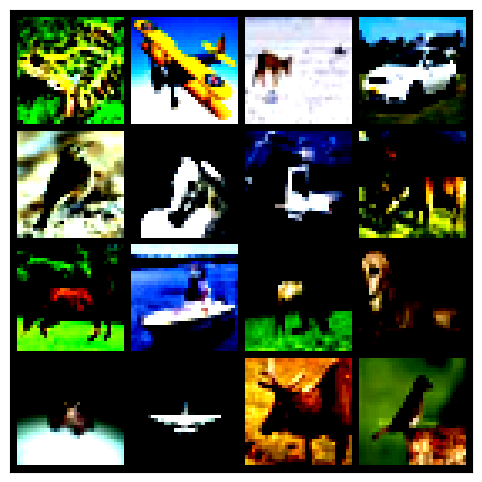

In [22]:
show_batch(train_loader)

In [23]:
# num of class is 10 because CIFAR-10  has 10 different class each has 6000 images 
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [24]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    acc = correct/total
    return acc

In [25]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    model.train()

    loss_save = []
    acc_save = []
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)

        # reset the gradients back to zero
        optimizer.zero_grad()

        # compute the output
        output = model(data)

        # calculate loss
        loss = loss_fn(output, target)
        loss_save.append(loss.item())

        # calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        acc = accuracy(correct, data.shape[0])
        acc_save.append(acc)

        # backpropagate the loss
        loss.backward()

        # update the parameters
        optimizer.step()

    return np.mean(loss_save), np.mean(acc_save)

    # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function

    model.eval()
    loss_save = []
    acc_save = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            
            # get the predictions
            output = model.forward(data)


            # calculate the loss
            loss = loss_fn(output, target)
            loss_save.append(loss.item())

            # get the correct number of predictions
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            # calculate the accuracy
            acc_save.append(accuracy(correct, data.shape[0]))

    return np.mean(loss_save), np.mean(acc_save)


In [26]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 

from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
    # - calls the train and validate functions for each epoch
    # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in trange(num_epochs, desc='Epoch'):  # trange is a tqdm wrapper around the normal python range that adds a progress bar

        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, epoch)
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, epoch)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Training epoch{epoch+1}: ')
        print(f'Training Loss: {train_loss:.3f}, Training Accuracy: {train_acc:.3f}')
        print(f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.3f}')

    print('Training process has finished.')
    return train_losses, val_losses, train_accs, val_accs

In [27]:
# TODO: write a function to calculate and return the confusion values

from sklearn.metrics import confusion_matrix

def calc_confusion_matrix(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device=device)
    lbllist=torch.zeros(0,dtype=torch.long, device=device)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

        # Confusion matrix
        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
        return conf_mat

## Logistic Regression   

In [28]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim=1):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        input_dimension = (x.shape[1] * x.shape[2] * x.shape[3])
        # TODO: flatten the input to a suitable size for the initial layer
        # x = x.reshape(-1, input_dimension)
        flattened = x.view(-1, input_dimension) # flatten the image

        # TODO: run the data through the layer
        outputs = torch.sigmoid(self.linear(flattened))
        return outputs

In [29]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
input_shape = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]*train_loader.dataset.data.shape[3]
linear_regression = LR(input_shape, num_classes).to(device)
linear_regression.train()
print(test_loader.dataset.data.shape[1], test_loader.dataset.data.shape[2], test_loader.dataset.data.shape[3])

32 32 3


In [30]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [31]:
# TODO: define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [32]:
## TODO: run training over 20 epochs

num_epochs = 20
train_loss, val_loss, train_acc, val_acc = run_training(linear_regression, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)




Epoch:   5%|▌         | 1/20 [00:14<04:44, 14.96s/it]

Training epoch1: 
Training Loss: 2.059, Training Accuracy: 0.325
Validation Loss: 2.034, Validation Accuracy: 0.352


Epoch:  10%|█         | 2/20 [00:29<04:25, 14.73s/it]

Training epoch2: 
Training Loss: 2.023, Training Accuracy: 0.357
Validation Loss: 2.026, Validation Accuracy: 0.349


Epoch:  15%|█▌        | 3/20 [00:43<04:08, 14.61s/it]

Training epoch3: 
Training Loss: 2.011, Training Accuracy: 0.369
Validation Loss: 2.012, Validation Accuracy: 0.371


Epoch:  20%|██        | 4/20 [00:58<03:54, 14.65s/it]

Training epoch4: 
Training Loss: 2.006, Training Accuracy: 0.372
Validation Loss: 2.005, Validation Accuracy: 0.371


Epoch:  25%|██▌       | 5/20 [01:13<03:38, 14.59s/it]

Training epoch5: 
Training Loss: 1.998, Training Accuracy: 0.376
Validation Loss: 2.006, Validation Accuracy: 0.377


Epoch:  30%|███       | 6/20 [01:27<03:24, 14.58s/it]

Training epoch6: 
Training Loss: 1.993, Training Accuracy: 0.378
Validation Loss: 1.999, Validation Accuracy: 0.386


Epoch:  35%|███▌      | 7/20 [01:42<03:09, 14.60s/it]

Training epoch7: 
Training Loss: 1.990, Training Accuracy: 0.385
Validation Loss: 2.004, Validation Accuracy: 0.368


Epoch:  40%|████      | 8/20 [01:57<02:55, 14.63s/it]

Training epoch8: 
Training Loss: 1.987, Training Accuracy: 0.382
Validation Loss: 2.000, Validation Accuracy: 0.377


Epoch:  45%|████▌     | 9/20 [02:11<02:40, 14.60s/it]

Training epoch9: 
Training Loss: 1.984, Training Accuracy: 0.382
Validation Loss: 1.998, Validation Accuracy: 0.377


Epoch:  50%|█████     | 10/20 [02:26<02:26, 14.62s/it]

Training epoch10: 
Training Loss: 1.980, Training Accuracy: 0.386
Validation Loss: 1.999, Validation Accuracy: 0.376


Epoch:  55%|█████▌    | 11/20 [02:40<02:11, 14.63s/it]

Training epoch11: 
Training Loss: 1.977, Training Accuracy: 0.384
Validation Loss: 1.993, Validation Accuracy: 0.389


Epoch:  60%|██████    | 12/20 [02:55<01:56, 14.57s/it]

Training epoch12: 
Training Loss: 1.976, Training Accuracy: 0.389
Validation Loss: 1.993, Validation Accuracy: 0.376


Epoch:  65%|██████▌   | 13/20 [03:10<01:42, 14.61s/it]

Training epoch13: 
Training Loss: 1.972, Training Accuracy: 0.390
Validation Loss: 1.990, Validation Accuracy: 0.383


Epoch:  70%|███████   | 14/20 [03:24<01:27, 14.60s/it]

Training epoch14: 
Training Loss: 1.971, Training Accuracy: 0.388
Validation Loss: 1.994, Validation Accuracy: 0.376


Epoch:  75%|███████▌  | 15/20 [03:39<01:13, 14.62s/it]

Training epoch15: 
Training Loss: 1.969, Training Accuracy: 0.389
Validation Loss: 1.994, Validation Accuracy: 0.375


Epoch:  80%|████████  | 16/20 [03:53<00:58, 14.62s/it]

Training epoch16: 
Training Loss: 1.969, Training Accuracy: 0.387
Validation Loss: 1.985, Validation Accuracy: 0.379


Epoch:  85%|████████▌ | 17/20 [04:08<00:43, 14.60s/it]

Training epoch17: 
Training Loss: 1.967, Training Accuracy: 0.392
Validation Loss: 1.988, Validation Accuracy: 0.383


Epoch:  90%|█████████ | 18/20 [04:22<00:29, 14.52s/it]

Training epoch18: 
Training Loss: 1.965, Training Accuracy: 0.392
Validation Loss: 1.988, Validation Accuracy: 0.379


Epoch:  95%|█████████▌| 19/20 [04:37<00:14, 14.50s/it]

Training epoch19: 
Training Loss: 1.963, Training Accuracy: 0.392
Validation Loss: 1.988, Validation Accuracy: 0.380


Epoch: 100%|██████████| 20/20 [04:52<00:00, 14.61s/it]

Training epoch20: 
Training Loss: 1.961, Training Accuracy: 0.393
Validation Loss: 1.985, Validation Accuracy: 0.390
Training process has finished.


In [33]:
def plot(iters, train_losses, validation_losses, train_acc, val_acc):
    plt.title("Learning Curve - losses")
    plt.plot(train_losses , '.-',label='training results')
    plt.plot(validation_losses, '.-' ,label='validation results')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.title("Learning Curve - accuracy")
    plt.plot(iters, train_acc, '.-', label="Train")
    plt.plot(iters, val_acc, '.-', label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()


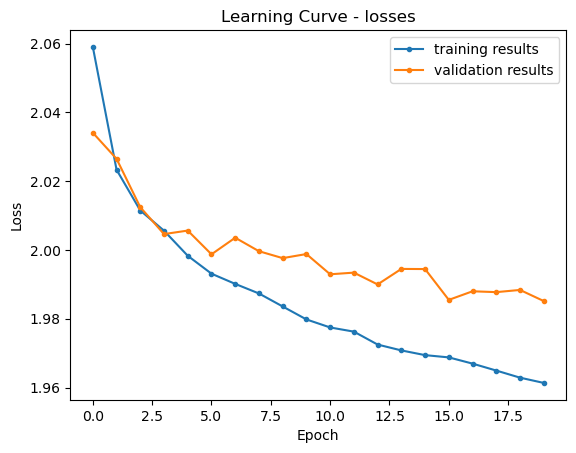

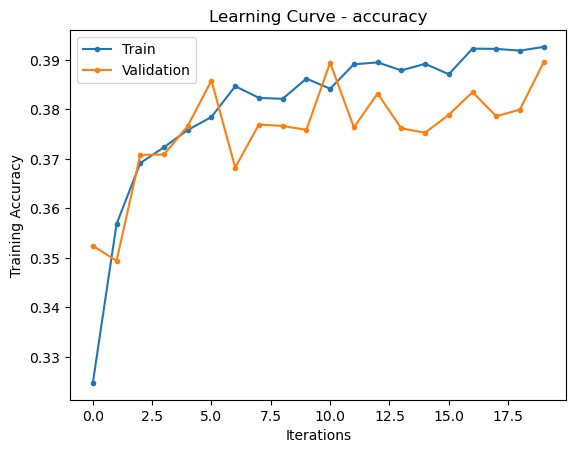

In [34]:
plot(range(num_epochs),train_loss,val_loss,train_acc,val_acc)


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

non-linearities allow us to go deeper and deeper into the network, and to learn more complex functions. Without non-linearities, the network doesn't increase the approximation power of a linear neural network at all, unlike for nonlinear neural network. And the gradient of a linear neural network goes to zero as the number of layers increases, so it's impossible to train a deep linear neural network. This problem has been solved by using a non-linear activation function like ReLU that assures that the gradient doesn't vanish by ignoring the negative values.

In [35]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity

        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1650),
            nn.ReLU(),
            nn.Linear(1650, 512),
            nn.ReLU(),
            nn.Linear(512, 138),
            nn.ReLU(),
            nn.Linear(138, output_dim)
        )
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input
        input_dim = (xb.shape[1] * xb.shape[2] * xb.shape[3])
        flattened = xb.view(-1, input_dim) # flatten the image
        activation = self.layers(flattened)

        return activation


In [36]:
## TODO: Define network, put it to device and train mode
mlp = MLP(input_shape, num_classes).to(device)
mlp.train()


MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=1650, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1650, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=138, bias=True)
    (5): ReLU()
    (6): Linear(in_features=138, out_features=10, bias=True)
  )
)

In [37]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()


In [38]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20
train_loss, val_loss, train_acc, val_acc = run_training(mlp, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)


Epoch:   5%|▌         | 1/20 [00:15<04:51, 15.33s/it]

Training epoch1: 
Training Loss: 1.665, Training Accuracy: 0.407
Validation Loss: 1.504, Validation Accuracy: 0.466


Epoch:  10%|█         | 2/20 [00:30<04:31, 15.10s/it]

Training epoch2: 
Training Loss: 1.459, Training Accuracy: 0.482
Validation Loss: 1.425, Validation Accuracy: 0.490


Epoch:  15%|█▌        | 3/20 [00:45<04:16, 15.10s/it]

Training epoch3: 
Training Loss: 1.359, Training Accuracy: 0.522
Validation Loss: 1.381, Validation Accuracy: 0.514


Epoch:  20%|██        | 4/20 [01:00<04:00, 15.05s/it]

Training epoch4: 
Training Loss: 1.285, Training Accuracy: 0.546
Validation Loss: 1.353, Validation Accuracy: 0.527


Epoch:  25%|██▌       | 5/20 [01:15<03:47, 15.15s/it]

Training epoch5: 
Training Loss: 1.222, Training Accuracy: 0.567
Validation Loss: 1.352, Validation Accuracy: 0.536


Epoch:  30%|███       | 6/20 [01:30<03:31, 15.10s/it]

Training epoch6: 
Training Loss: 1.167, Training Accuracy: 0.588
Validation Loss: 1.328, Validation Accuracy: 0.540


Epoch:  35%|███▌      | 7/20 [01:45<03:16, 15.13s/it]

Training epoch7: 
Training Loss: 1.115, Training Accuracy: 0.603
Validation Loss: 1.307, Validation Accuracy: 0.550


Epoch:  40%|████      | 8/20 [02:01<03:01, 15.16s/it]

Training epoch8: 
Training Loss: 1.071, Training Accuracy: 0.621
Validation Loss: 1.308, Validation Accuracy: 0.554


Epoch:  45%|████▌     | 9/20 [02:16<02:47, 15.21s/it]

Training epoch9: 
Training Loss: 1.027, Training Accuracy: 0.633
Validation Loss: 1.309, Validation Accuracy: 0.560


Epoch:  50%|█████     | 10/20 [02:31<02:31, 15.18s/it]

Training epoch10: 
Training Loss: 0.977, Training Accuracy: 0.651
Validation Loss: 1.313, Validation Accuracy: 0.561


Epoch:  55%|█████▌    | 11/20 [02:46<02:15, 15.09s/it]

Training epoch11: 
Training Loss: 0.936, Training Accuracy: 0.667
Validation Loss: 1.317, Validation Accuracy: 0.561


Epoch:  60%|██████    | 12/20 [03:01<02:00, 15.12s/it]

Training epoch12: 
Training Loss: 0.893, Training Accuracy: 0.682
Validation Loss: 1.347, Validation Accuracy: 0.561


Epoch:  65%|██████▌   | 13/20 [03:16<01:45, 15.07s/it]

Training epoch13: 
Training Loss: 0.856, Training Accuracy: 0.696
Validation Loss: 1.357, Validation Accuracy: 0.574


Epoch:  70%|███████   | 14/20 [03:31<01:30, 15.09s/it]

Training epoch14: 
Training Loss: 0.815, Training Accuracy: 0.710
Validation Loss: 1.394, Validation Accuracy: 0.558


Epoch:  75%|███████▌  | 15/20 [03:46<01:15, 15.01s/it]

Training epoch15: 
Training Loss: 0.776, Training Accuracy: 0.722
Validation Loss: 1.423, Validation Accuracy: 0.555


Epoch:  80%|████████  | 16/20 [04:02<01:00, 15.17s/it]

Training epoch16: 
Training Loss: 0.735, Training Accuracy: 0.736
Validation Loss: 1.497, Validation Accuracy: 0.567


Epoch:  85%|████████▌ | 17/20 [04:17<00:45, 15.22s/it]

Training epoch17: 
Training Loss: 0.701, Training Accuracy: 0.749
Validation Loss: 1.504, Validation Accuracy: 0.561


Epoch:  90%|█████████ | 18/20 [04:33<00:30, 15.40s/it]

Training epoch18: 
Training Loss: 0.669, Training Accuracy: 0.760
Validation Loss: 1.490, Validation Accuracy: 0.562


Epoch:  95%|█████████▌| 19/20 [04:48<00:15, 15.33s/it]

Training epoch19: 
Training Loss: 0.632, Training Accuracy: 0.773
Validation Loss: 1.579, Validation Accuracy: 0.553


Epoch: 100%|██████████| 20/20 [05:03<00:00, 15.18s/it]

Training epoch20: 
Training Loss: 0.606, Training Accuracy: 0.784
Validation Loss: 1.648, Validation Accuracy: 0.564
Training process has finished.


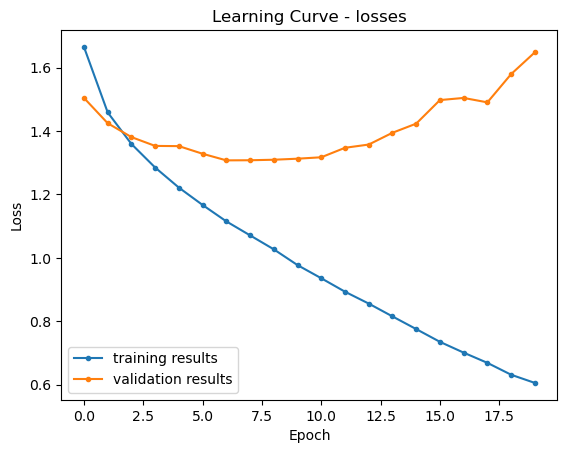

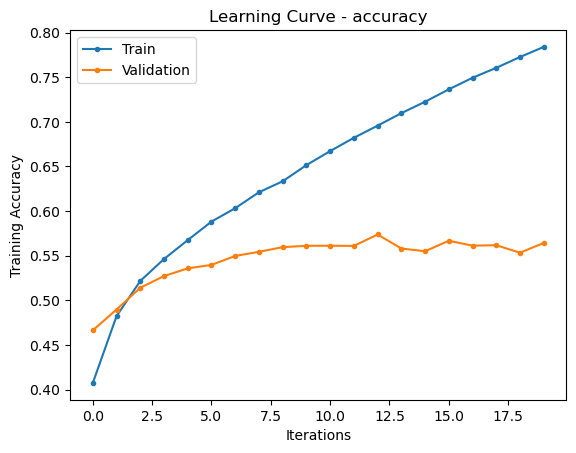

In [39]:
plot(range(num_epochs),train_loss,val_loss,train_acc,val_acc)

## Add L2 regularisation

In [40]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength

mlp2 = MLP(input_shape, num_classes).to(device)
mlp2.train()
optimizer2 = torch.optim.Adam(mlp2.parameters(), lr=0.001, weight_decay=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()


In [41]:
## TODO: Retrain new model with regularization over 20 epochs
num_epochs = 20
train_loss, val_loss, train_acc, val_acc = run_training(mlp2, optimizer2, loss_fn, device, num_epochs, train_loader, test_loader)


Epoch:   5%|▌         | 1/20 [00:15<04:48, 15.18s/it]

Training epoch1: 
Training Loss: 1.671, Training Accuracy: 0.407
Validation Loss: 1.553, Validation Accuracy: 0.452


Epoch:  10%|█         | 2/20 [00:30<04:34, 15.22s/it]

Training epoch2: 
Training Loss: 1.503, Training Accuracy: 0.469
Validation Loss: 1.438, Validation Accuracy: 0.494


Epoch:  15%|█▌        | 3/20 [00:45<04:16, 15.08s/it]

Training epoch3: 
Training Loss: 1.430, Training Accuracy: 0.496
Validation Loss: 1.430, Validation Accuracy: 0.492


Epoch:  20%|██        | 4/20 [01:00<04:00, 15.02s/it]

Training epoch4: 
Training Loss: 1.384, Training Accuracy: 0.512
Validation Loss: 1.405, Validation Accuracy: 0.506


Epoch:  25%|██▌       | 5/20 [01:15<03:44, 14.94s/it]

Training epoch5: 
Training Loss: 1.344, Training Accuracy: 0.525
Validation Loss: 1.368, Validation Accuracy: 0.515


Epoch:  30%|███       | 6/20 [01:30<03:29, 14.95s/it]

Training epoch6: 
Training Loss: 1.306, Training Accuracy: 0.536
Validation Loss: 1.351, Validation Accuracy: 0.525


Epoch:  35%|███▌      | 7/20 [01:44<03:13, 14.91s/it]

Training epoch7: 
Training Loss: 1.287, Training Accuracy: 0.543
Validation Loss: 1.356, Validation Accuracy: 0.518


Epoch:  40%|████      | 8/20 [01:59<02:59, 14.95s/it]

Training epoch8: 
Training Loss: 1.256, Training Accuracy: 0.554
Validation Loss: 1.378, Validation Accuracy: 0.522


Epoch:  45%|████▌     | 9/20 [02:14<02:44, 14.94s/it]

Training epoch9: 
Training Loss: 1.226, Training Accuracy: 0.564
Validation Loss: 1.311, Validation Accuracy: 0.537


Epoch:  50%|█████     | 10/20 [02:29<02:29, 14.96s/it]

Training epoch10: 
Training Loss: 1.204, Training Accuracy: 0.571
Validation Loss: 1.362, Validation Accuracy: 0.529


Epoch:  55%|█████▌    | 11/20 [02:44<02:14, 14.93s/it]

Training epoch11: 
Training Loss: 1.194, Training Accuracy: 0.575
Validation Loss: 1.316, Validation Accuracy: 0.533


Epoch:  60%|██████    | 12/20 [02:59<01:59, 14.93s/it]

Training epoch12: 
Training Loss: 1.171, Training Accuracy: 0.585
Validation Loss: 1.292, Validation Accuracy: 0.544


Epoch:  65%|██████▌   | 13/20 [03:14<01:44, 14.88s/it]

Training epoch13: 
Training Loss: 1.152, Training Accuracy: 0.590
Validation Loss: 1.315, Validation Accuracy: 0.546


Epoch:  70%|███████   | 14/20 [03:29<01:29, 14.85s/it]

Training epoch14: 
Training Loss: 1.134, Training Accuracy: 0.596
Validation Loss: 1.303, Validation Accuracy: 0.545


Epoch:  75%|███████▌  | 15/20 [03:44<01:14, 14.86s/it]

Training epoch15: 
Training Loss: 1.119, Training Accuracy: 0.602
Validation Loss: 1.304, Validation Accuracy: 0.554


Epoch:  80%|████████  | 16/20 [03:58<00:59, 14.85s/it]

Training epoch16: 
Training Loss: 1.100, Training Accuracy: 0.608
Validation Loss: 1.284, Validation Accuracy: 0.550


Epoch:  85%|████████▌ | 17/20 [04:13<00:44, 14.80s/it]

Training epoch17: 
Training Loss: 1.090, Training Accuracy: 0.614
Validation Loss: 1.273, Validation Accuracy: 0.558


Epoch:  90%|█████████ | 18/20 [04:28<00:29, 14.85s/it]

Training epoch18: 
Training Loss: 1.074, Training Accuracy: 0.619
Validation Loss: 1.298, Validation Accuracy: 0.548


Epoch:  95%|█████████▌| 19/20 [04:44<00:15, 15.15s/it]

Training epoch19: 
Training Loss: 1.066, Training Accuracy: 0.621
Validation Loss: 1.251, Validation Accuracy: 0.567


Epoch: 100%|██████████| 20/20 [05:00<00:00, 15.03s/it]

Training epoch20: 
Training Loss: 1.045, Training Accuracy: 0.627
Validation Loss: 1.268, Validation Accuracy: 0.560
Training process has finished.


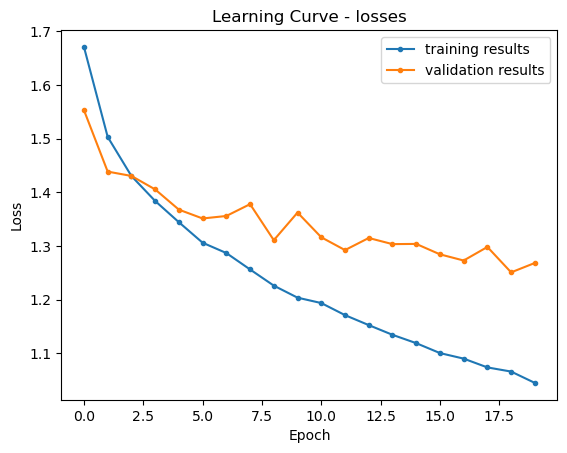

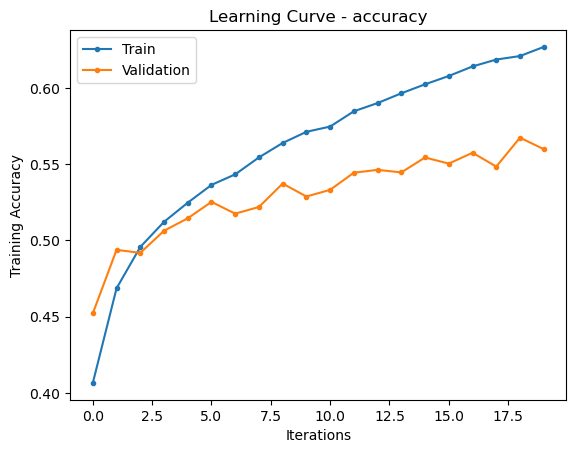

In [42]:
plot(range(num_epochs),train_loss,val_loss,train_acc,val_acc)

## LeNet5

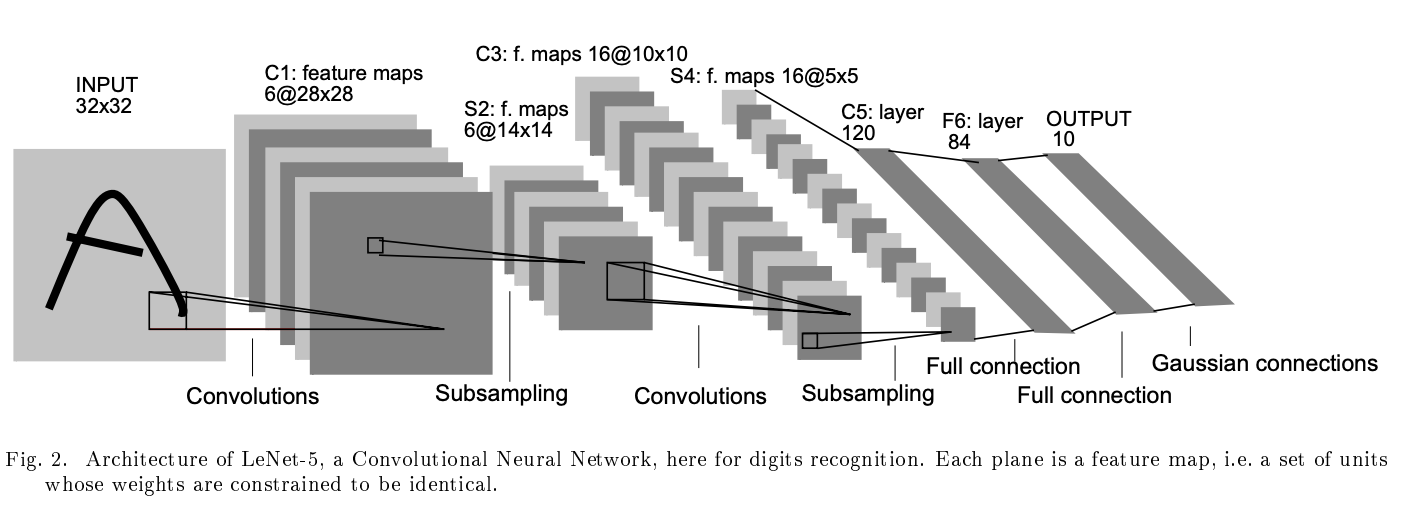

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [43]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1), #C1
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2), #S2
            
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), #C3
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2), #S4
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), #C5
            nn.ReLU(),

        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [44]:
## TODO: define network, put it to the device and train mode
CCN = LeNet5(n_classes=10, in_channels=3)
CCN.to(device)
CCN.train()


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [45]:
## TODO: define loss function and optimisers

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CCN.parameters(), lr=0.001)

In [46]:
## TODO: train with 20 epochs
num_epochs = 20
train_loss, val_loss, train_acc, val_acc = run_training(model=CCN, optimizer=optimizer, loss_function=loss_fn, device=device, num_epochs=num_epochs, train_dataloader=train_loader, val_dataloader=test_loader)


Epoch:   5%|▌         | 1/20 [00:17<05:28, 17.30s/it]

Training epoch1: 
Training Loss: 1.834, Training Accuracy: 0.333
Validation Loss: 1.640, Validation Accuracy: 0.414


Epoch:  10%|█         | 2/20 [00:34<05:08, 17.11s/it]

Training epoch2: 
Training Loss: 1.552, Training Accuracy: 0.442
Validation Loss: 1.480, Validation Accuracy: 0.473


Epoch:  15%|█▌        | 3/20 [00:50<04:46, 16.83s/it]

Training epoch3: 
Training Loss: 1.456, Training Accuracy: 0.481
Validation Loss: 1.405, Validation Accuracy: 0.501


Epoch:  20%|██        | 4/20 [01:07<04:26, 16.63s/it]

Training epoch4: 
Training Loss: 1.392, Training Accuracy: 0.501
Validation Loss: 1.363, Validation Accuracy: 0.513


Epoch:  25%|██▌       | 5/20 [01:23<04:08, 16.54s/it]

Training epoch5: 
Training Loss: 1.344, Training Accuracy: 0.518
Validation Loss: 1.318, Validation Accuracy: 0.527


Epoch:  30%|███       | 6/20 [01:39<03:48, 16.32s/it]

Training epoch6: 
Training Loss: 1.294, Training Accuracy: 0.536
Validation Loss: 1.293, Validation Accuracy: 0.539


Epoch:  35%|███▌      | 7/20 [01:54<03:28, 16.07s/it]

Training epoch7: 
Training Loss: 1.258, Training Accuracy: 0.549
Validation Loss: 1.256, Validation Accuracy: 0.553


Epoch:  40%|████      | 8/20 [02:10<03:10, 15.91s/it]

Training epoch8: 
Training Loss: 1.219, Training Accuracy: 0.565
Validation Loss: 1.217, Validation Accuracy: 0.569


Epoch:  45%|████▌     | 9/20 [02:26<02:54, 15.88s/it]

Training epoch9: 
Training Loss: 1.185, Training Accuracy: 0.579
Validation Loss: 1.197, Validation Accuracy: 0.571


Epoch:  50%|█████     | 10/20 [02:41<02:38, 15.80s/it]

Training epoch10: 
Training Loss: 1.154, Training Accuracy: 0.589
Validation Loss: 1.190, Validation Accuracy: 0.571


Epoch:  55%|█████▌    | 11/20 [02:57<02:21, 15.75s/it]

Training epoch11: 
Training Loss: 1.129, Training Accuracy: 0.599
Validation Loss: 1.183, Validation Accuracy: 0.578


Epoch:  60%|██████    | 12/20 [03:13<02:05, 15.70s/it]

Training epoch12: 
Training Loss: 1.104, Training Accuracy: 0.608
Validation Loss: 1.152, Validation Accuracy: 0.593


Epoch:  65%|██████▌   | 13/20 [03:28<01:49, 15.67s/it]

Training epoch13: 
Training Loss: 1.080, Training Accuracy: 0.617
Validation Loss: 1.139, Validation Accuracy: 0.595


Epoch:  70%|███████   | 14/20 [03:44<01:34, 15.67s/it]

Training epoch14: 
Training Loss: 1.055, Training Accuracy: 0.627
Validation Loss: 1.116, Validation Accuracy: 0.607


Epoch:  75%|███████▌  | 15/20 [03:59<01:17, 15.57s/it]

Training epoch15: 
Training Loss: 1.035, Training Accuracy: 0.635
Validation Loss: 1.096, Validation Accuracy: 0.618


Epoch:  80%|████████  | 16/20 [04:15<01:02, 15.53s/it]

Training epoch16: 
Training Loss: 1.020, Training Accuracy: 0.640
Validation Loss: 1.085, Validation Accuracy: 0.618


Epoch:  85%|████████▌ | 17/20 [04:30<00:46, 15.52s/it]

Training epoch17: 
Training Loss: 0.997, Training Accuracy: 0.649
Validation Loss: 1.074, Validation Accuracy: 0.622


Epoch:  90%|█████████ | 18/20 [04:46<00:31, 15.56s/it]

Training epoch18: 
Training Loss: 0.982, Training Accuracy: 0.654
Validation Loss: 1.062, Validation Accuracy: 0.629


Epoch:  95%|█████████▌| 19/20 [05:01<00:15, 15.53s/it]

Training epoch19: 
Training Loss: 0.968, Training Accuracy: 0.659
Validation Loss: 1.047, Validation Accuracy: 0.633


Epoch: 100%|██████████| 20/20 [05:17<00:00, 15.88s/it]

Training epoch20: 
Training Loss: 0.949, Training Accuracy: 0.666
Validation Loss: 1.056, Validation Accuracy: 0.626
Training process has finished.


## Analysis 

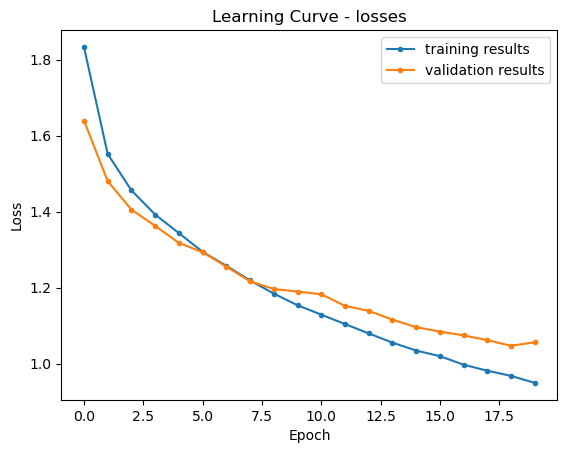

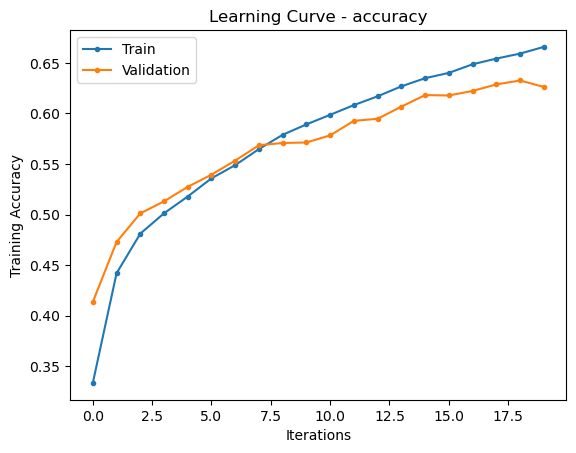

In [47]:
## TODO: Plot both train and val losses for all models. 
## What do you see?
plot(range(num_epochs),train_loss,val_loss,train_acc,val_acc)

In [61]:
## TODO: Plot the confusion matrix for LeNet5

def predict_dl(model, data):
    model.eval()
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

y_pred, y_true = predict_dl(CCN, test_loader)

#y_pred, y_ture = predict(model=CCN, dataloader=test_loader, device=device)
conf_mat = confusion_matrix(y_true, y_pred, labels=range(10))
#pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

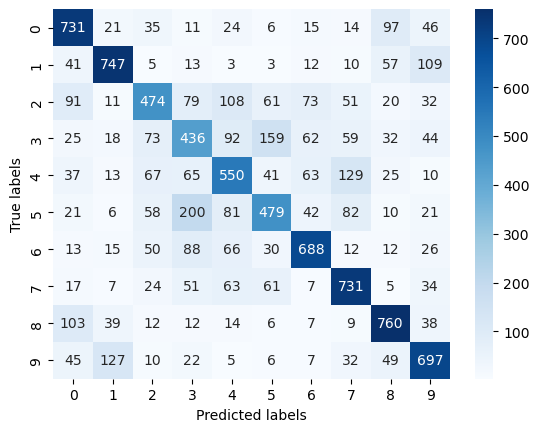

In [62]:
import seaborn as sns

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?